<a href="https://colab.research.google.com/github/Ibtihaj-Khan/MNIST-VGG-Model/blob/main/MNIST_VGG_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import requests
from timeit import default_timer as timer
from tqdm.auto import tqdm

#Using accuracy function from this source (Thanks)
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [13]:
#init device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
#Getting test and train data
train_data = datasets.MNIST(root="data",
                            train=True,
                            transform=ToTensor(),
                            download=True)

test_data = datasets.MNIST(root="data",
                           train=False,
                           transform=ToTensor(),
                           download=True)

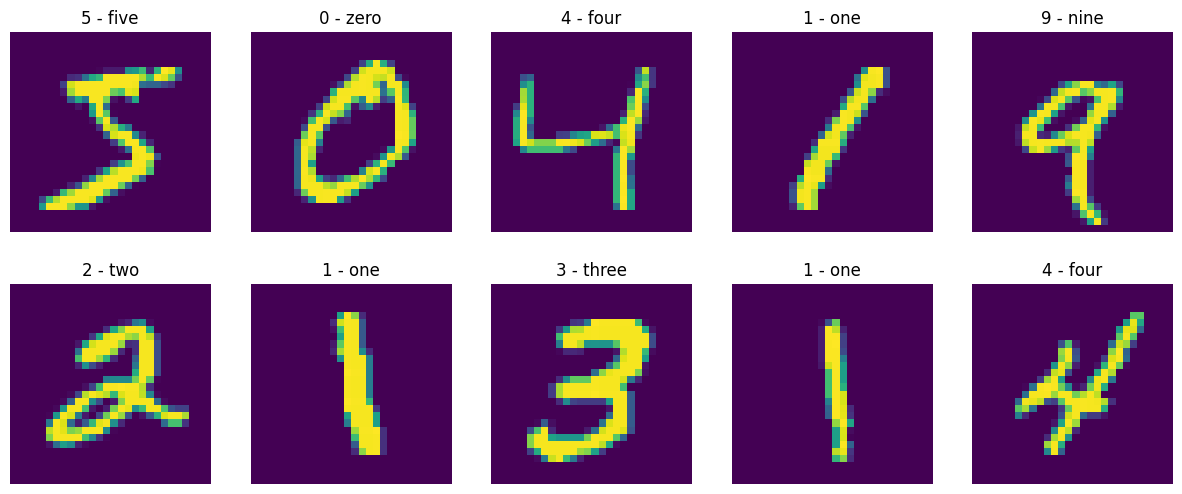

In [15]:
#Getting class names, and plotting some samples to figure out what this is.

class_names = train_data.classes

plt.subplots(2,5, figsize=(15, 6))

for i in range(len(class_names)):
  sample_image, sample_label = train_data[i]
  plt.subplot(2,5,i+1)
  plt.imshow(sample_image.squeeze())
  plt.title(class_names[sample_label])
  plt.axis(False)

In [16]:
sample_image, sample_label=test_data[5]
sample_image.shape, sample_label

(torch.Size([1, 28, 28]), 1)

What we can see in the data set is that this is a bunch of numbers images. The torch shape tells us that this is a 28 x 28 image with 1 color channel, and each image maps up to one label. This is a computer vision multiclass classification problem where we will take pictures of numbers and guess what they are.

We can begin by converting data into data loaders, create a model, do a dummy pass, prepare our functionalized training and test steps, and train the model.

In [17]:
#Prep our data into data loaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32)

Preparing a model in the architecture of the tiny VGG model: https://poloclub.github.io/cnn-explainer/

Two Convolutional blocks (Conv2d -> Relu -> Conv2d -> Relu -> MaxPool) x 2
followed by an output layer

In [18]:
class TinyVGG(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
    super().__init__()

    self.block_1=nn.Sequential(
        nn.Conv2d(in_channels=in_features,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.output_layer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, #When we ran dummy pass without multipliers, we determined these by seeing shape change
                  out_features=out_features)
    )

  def forward(self, x):
    #print(x.shape)
    x=self.block_1(x)
    #print(x.shape)
    x=self.block_2(x)
    #print(x.shape)
    x=self.output_layer(x)
    #print(x.shape)
    return x

Do a dummy pass to figure out output layer in_feature multiplier based on printed output of shape as it passes through the model.

In [19]:
#Instantiate model
IN_FEATURES = 1 #One channel per image
HIDDEN_UNITS = 10 #10 units are in the tiny vgg model we are replicating
OUT_FEATURES = len(class_names) #Total possible output classes

model_0 = TinyVGG(IN_FEATURES, HIDDEN_UNITS, OUT_FEATURES)
y_logit = model_0(sample_image.unsqueeze(dim=1)) #add dummy batch dimension
y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
print(y_logit, y_pred)

#Initialize loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.04)

tensor([[ 0.0054,  0.0517, -0.0179, -0.0267, -0.0392,  0.0465,  0.0049,  0.0020,
          0.0269, -0.0453]], grad_fn=<AddmmBackward0>) tensor([1])


We see that our dummy pass is giving us length 10 output logits, which is in line with our expectations for 10 total possible classes! This means out model is atleast giving us output in the expected shape. We can proceed to create training and test steps.

In [20]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn, optimizer, accuracy_fn,
               device = device):

  train_loss, train_acc = 0, 0

  #Model in training mode
  model.to(device)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    #Send data to device like model
    X, y = X.to(device), y.to(device)

    #Do the forward pass, get logits and predictions
    train_logits = model(X)
    train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)

    #Calculate the loss and accuracy, increment totals
    loss = loss_fn(train_logits, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                            y_pred=train_pred)

    #Zero optimizer grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #step optimizer
    optimizer.step()

  #divide total loss/accuracy by length of data
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}%")

In [21]:
def test_step(model:nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn, accuracy_fn,
              device = device):

  test_loss, test_acc = 0, 0

  #Model in evaluation mode
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):

      #Sending data to target device
      X, y = X.to(device), y.to(device)

      #Forward pass
      test_logits = model(X)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      #Calculate loss and accuracy
      loss = loss_fn(test_logits, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test loss: {test_loss} | Test acc: {test_acc}%")

Time to kick off the training and see how it goes.

In [22]:
epochs = 8

start_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"\n-------------Epoch {epoch}-------------")

  train_step(model=model_0,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)

  test_step(model=model_0,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

end_time = timer()

print(f"Total training time: {end_time-start_time:.2f}.")

  0%|          | 0/8 [00:00<?, ?it/s]


-------------Epoch 0-------------
Training Loss: 0.48223981261253357 | Training Accuracy: 83.09666666666666%
Test loss: 0.0854867696762085 | Test acc: 97.29432907348243%

-------------Epoch 1-------------
Training Loss: 0.08815184980630875 | Training Accuracy: 97.30833333333334%
Test loss: 0.06970030069351196 | Test acc: 97.83346645367412%

-------------Epoch 2-------------
Training Loss: 0.06947116553783417 | Training Accuracy: 97.85%
Test loss: 0.051310066133737564 | Test acc: 98.23282747603834%

-------------Epoch 3-------------
Training Loss: 0.058888889849185944 | Training Accuracy: 98.16666666666667%
Test loss: 0.049005988985300064 | Test acc: 98.31269968051119%

-------------Epoch 4-------------
Training Loss: 0.05264013633131981 | Training Accuracy: 98.33833333333334%
Test loss: 0.04575319588184357 | Test acc: 98.46246006389777%

-------------Epoch 5-------------
Training Loss: 0.04634423553943634 | Training Accuracy: 98.615%
Test loss: 0.04327936843037605 | Test acc: 98.64217

Well, this is very good results on paper. It looks like our model is super accurate with very low loss. In order to make sure we actually set it up correctly, lets make some predictions and plot a confusion matrix to see.

In [23]:
#Install metrics
!pip install torchmetrics -q

import torchmetrics, mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.5 MB/s eta 0:00:00


In [30]:
#Make predictions
y_preds = []

model_0.to(device)
model_0.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X = X.to(device)

    y_logits = model_0(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [31]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [33]:
#Create the confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")

confmat_tensor = confmat(y_pred_tensor.to("cpu"), test_data.targets)
confmat_tensor

tensor([[ 979,    0,    0,    0,    0,    1,    0,    0,    0,    0],
        [   0, 1122,    4,    0,    0,    0,    4,    1,    4,    0],
        [   3,    0, 1014,    6,    1,    0,    0,    2,    5,    1],
        [   0,    0,    0, 1002,    0,    3,    0,    2,    3,    0],
        [   1,    0,    2,    0,  962,    0,    1,    0,    4,   12],
        [   1,    0,    0,    4,    0,  883,    1,    1,    1,    1],
        [   9,    2,    0,    1,    2,    3,  936,    0,    5,    0],
        [   0,    1,    7,    1,    0,    1,    0, 1014,    3,    1],
        [   2,    0,    3,    2,    1,    1,    0,    1,  963,    1],
        [   1,    1,    0,    1,    4,    8,    0,    5,    6,  983]])

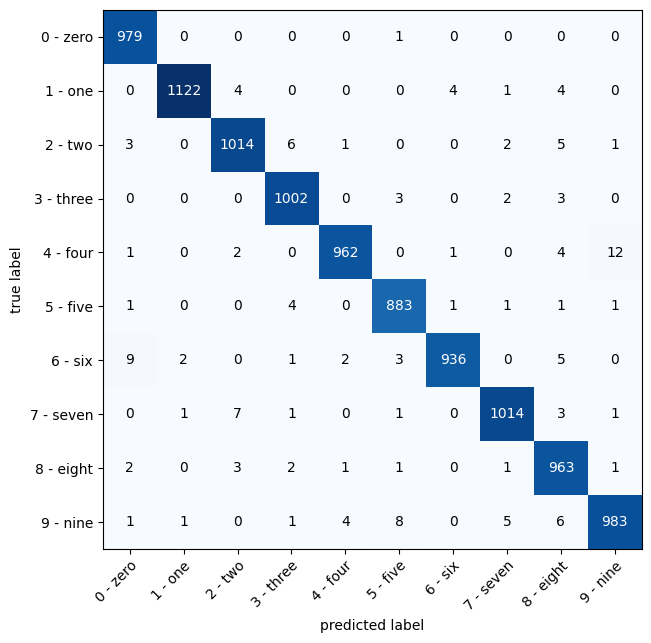

In [36]:
fix, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,7))

This is very fantastic. Our model is almost always dead on with its predictions, with a few getting confused, for example 9 and 4, and 0 and 6. With the way some of these can be drawn, its can make some sense so we can conclude this model is pretty good.